In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap
import seaborn as sns
import matplotlib.pyplot as plt

/home/kchen/miniconda3/envs/tf/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/kchen/miniconda3/envs/tf/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_

Running folfox OS
(1106, 469) (277, 469)
            AUROC     AUPRC    Recall  Precision
XGBoost  0.764025  0.772476  0.742857   0.684211


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Running folfox PFS
(828, 469) (207, 469)
           AUROC     AUPRC    Recall  Precision
XGBoost  0.47297  0.290418  0.225806   0.291667


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Running egfr OS
(283, 469) (71, 469)
            AUROC     AUPRC    Recall  Precision
XGBoost  0.738225  0.770319  0.833333   0.851064


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Running egfr PFS
(278, 469) (70, 469)
           AUROC     AUPRC    Recall  Precision
XGBoost  0.66585  0.641532  0.705882   0.585366


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Running vegf OS
(737, 469) (185, 469)
            AUROC     AUPRC    Recall  Precision
XGBoost  0.765711  0.851477  0.846154   0.738806


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Running vegf PFS
(710, 469) (178, 469)
            AUROC     AUPRC    Recall  Precision
XGBoost  0.581302  0.453467  0.430556   0.484375


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Running ib OS
(116, 469) (30, 469)
            AUROC     AUPRC    Recall  Precision
XGBoost  0.704545  0.847713  0.954545       0.84


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Running ib PFS
(110, 469) (28, 469)
            AUROC     AUPRC    Recall  Precision
XGBoost  0.469388  0.783003  0.714286   0.714286


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


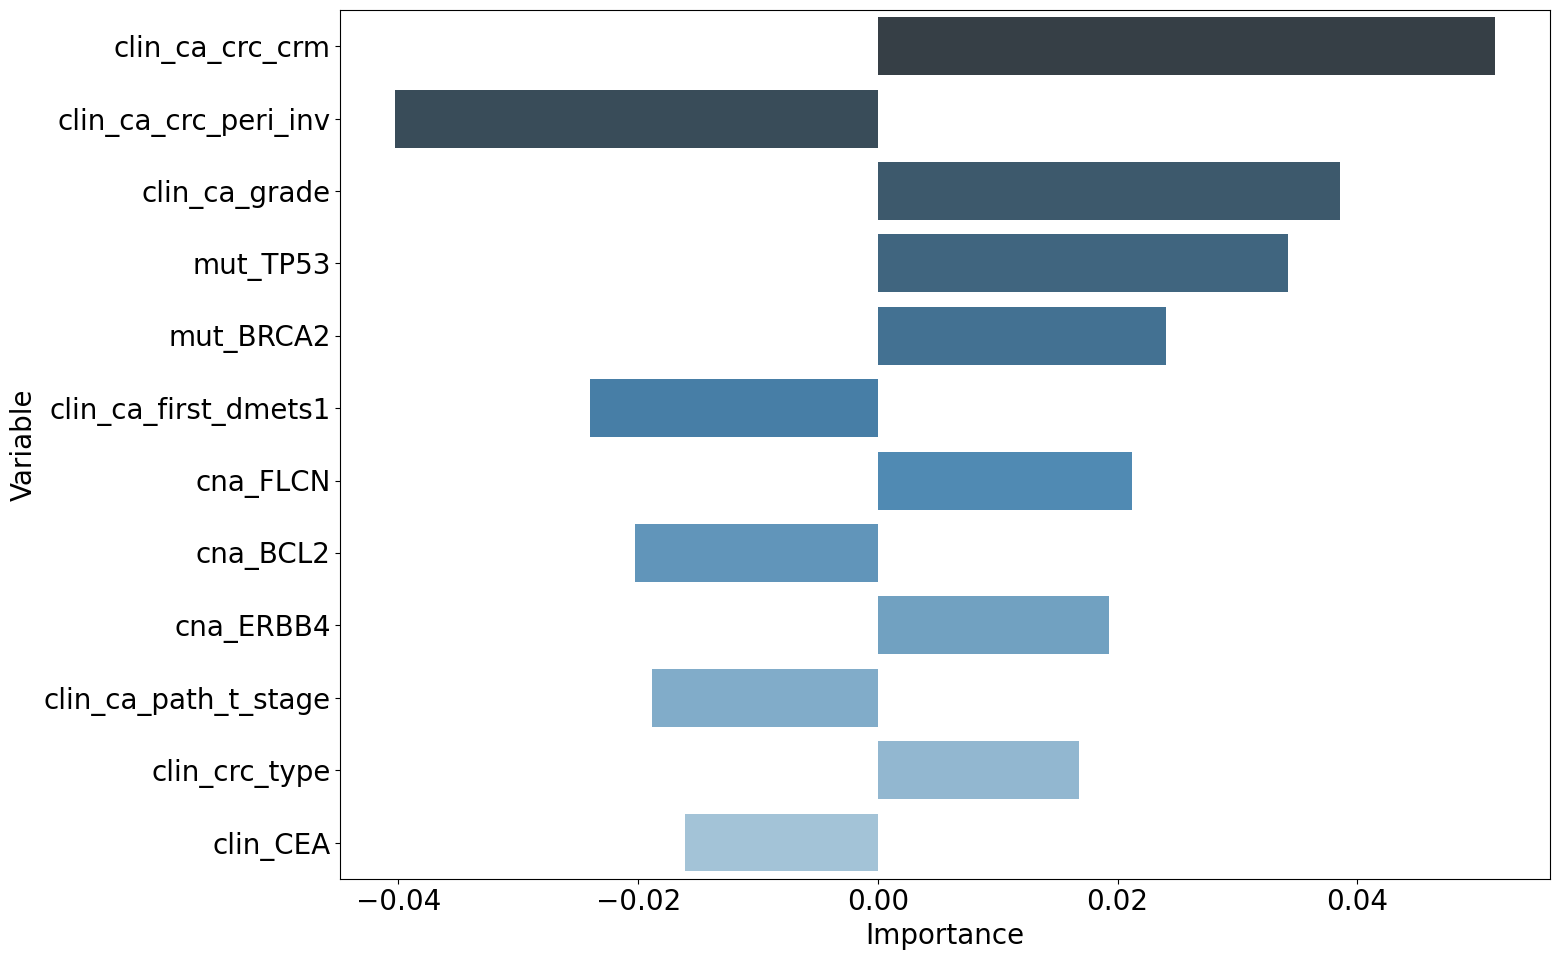

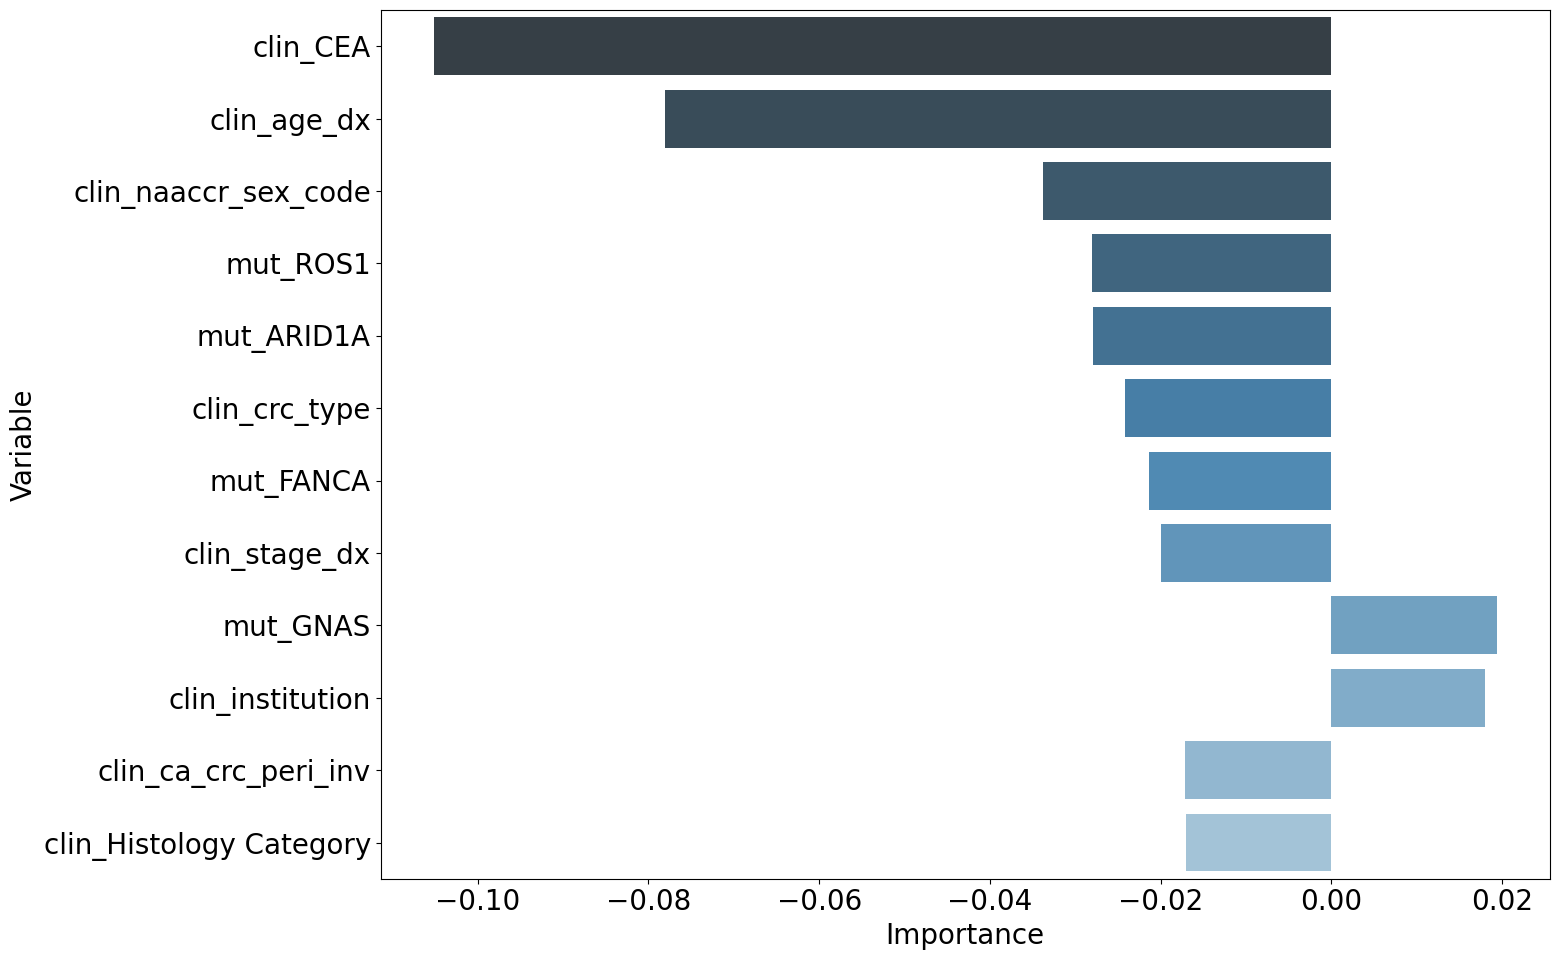

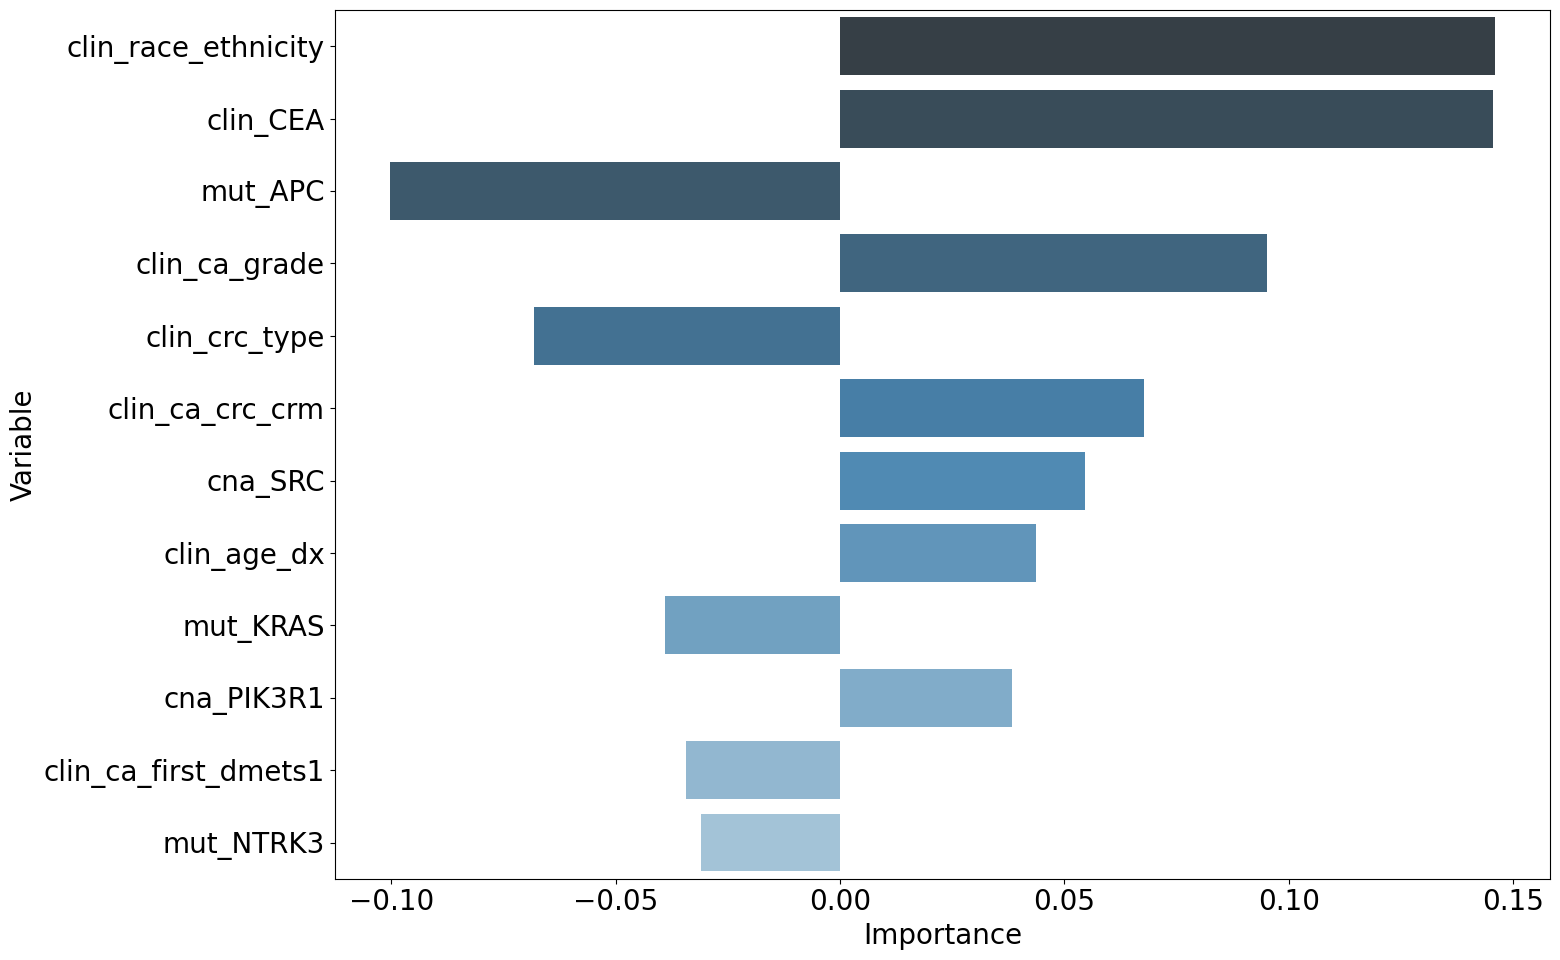

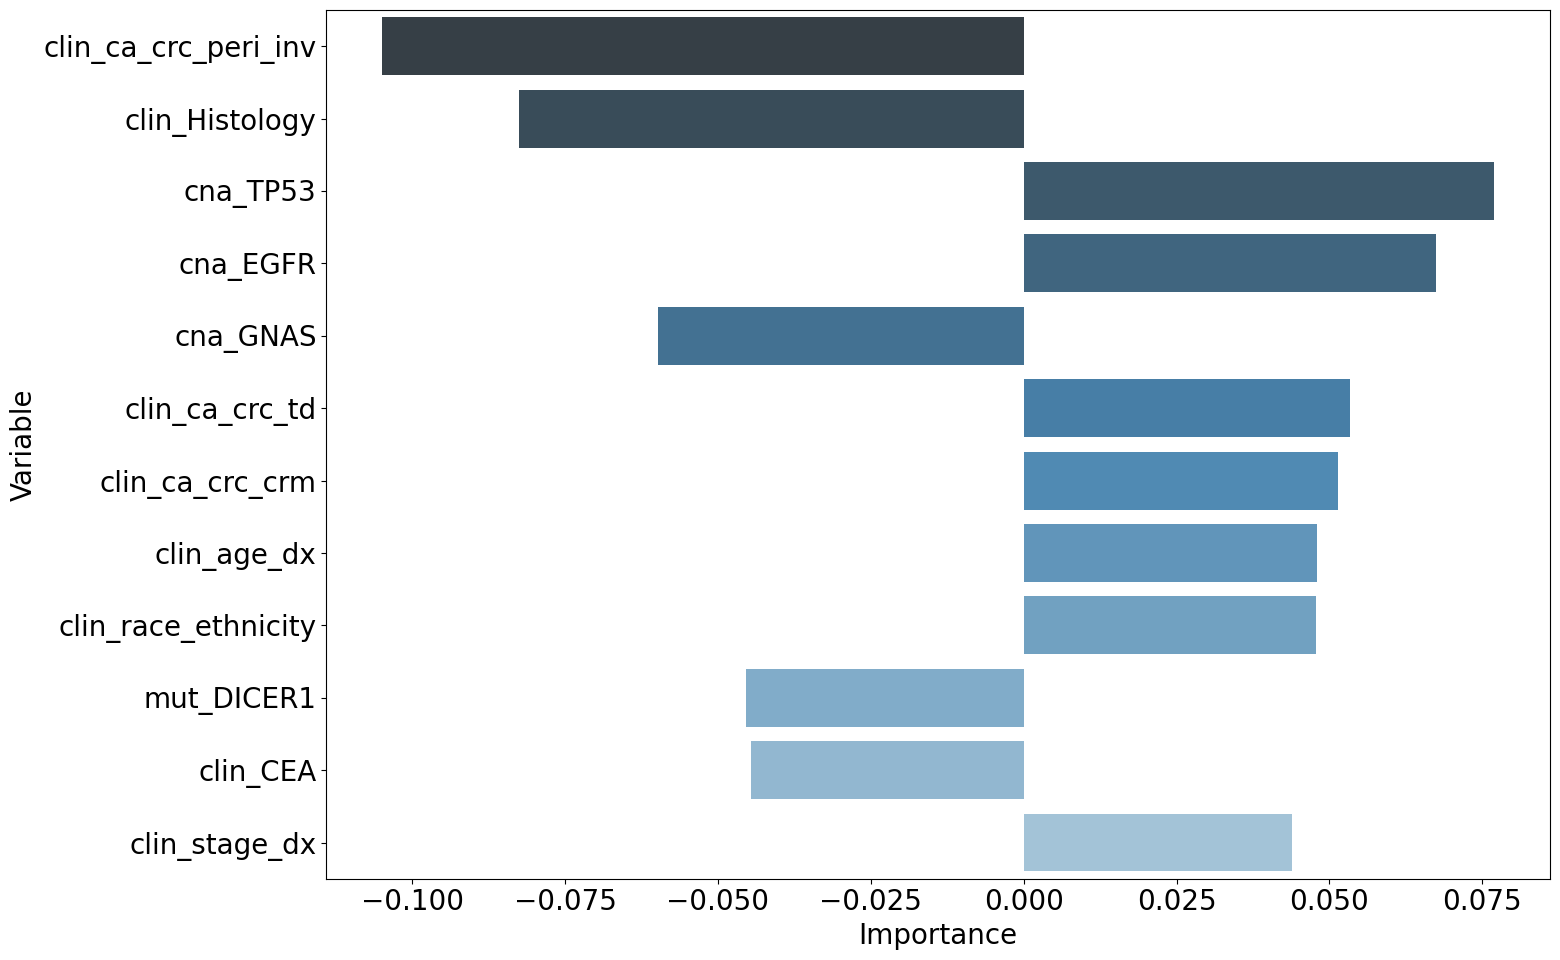

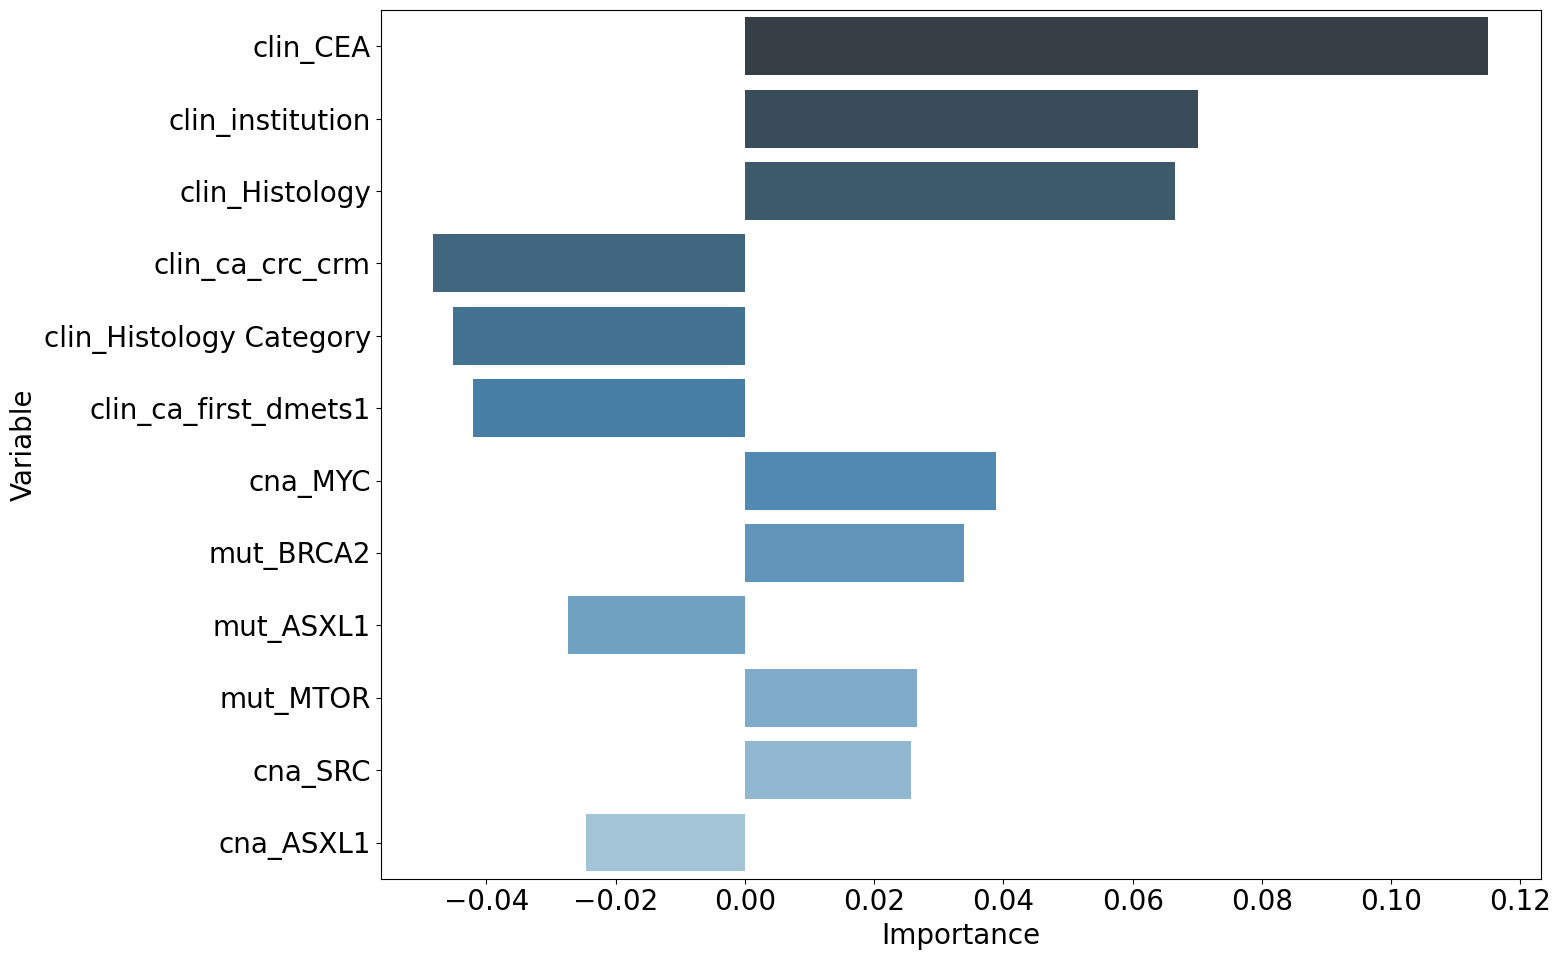

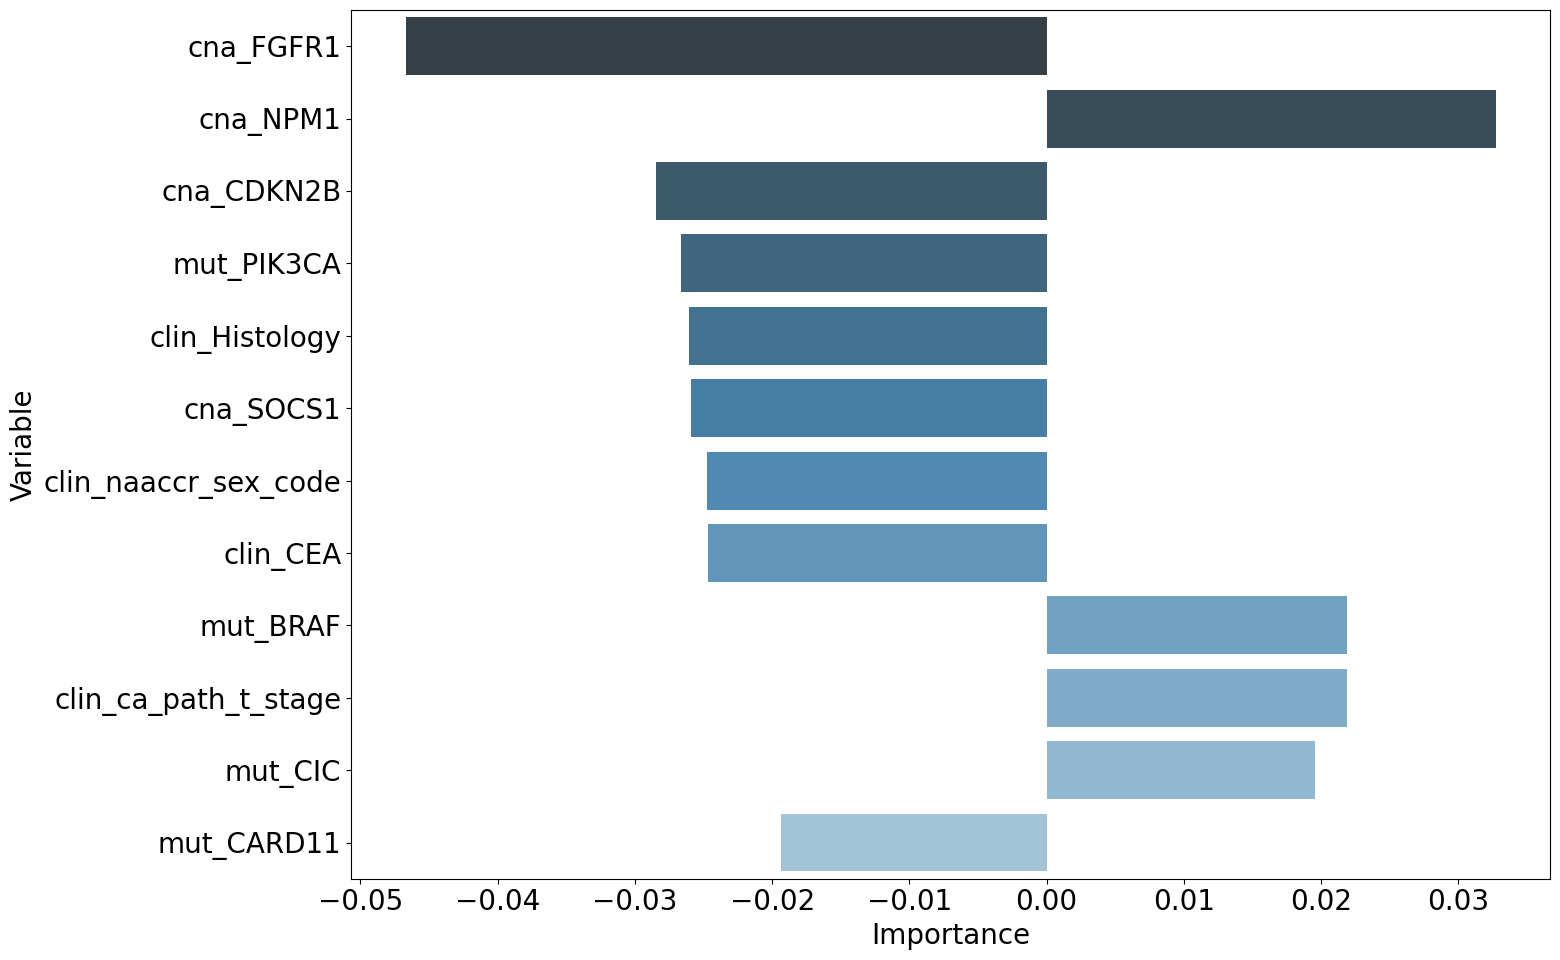

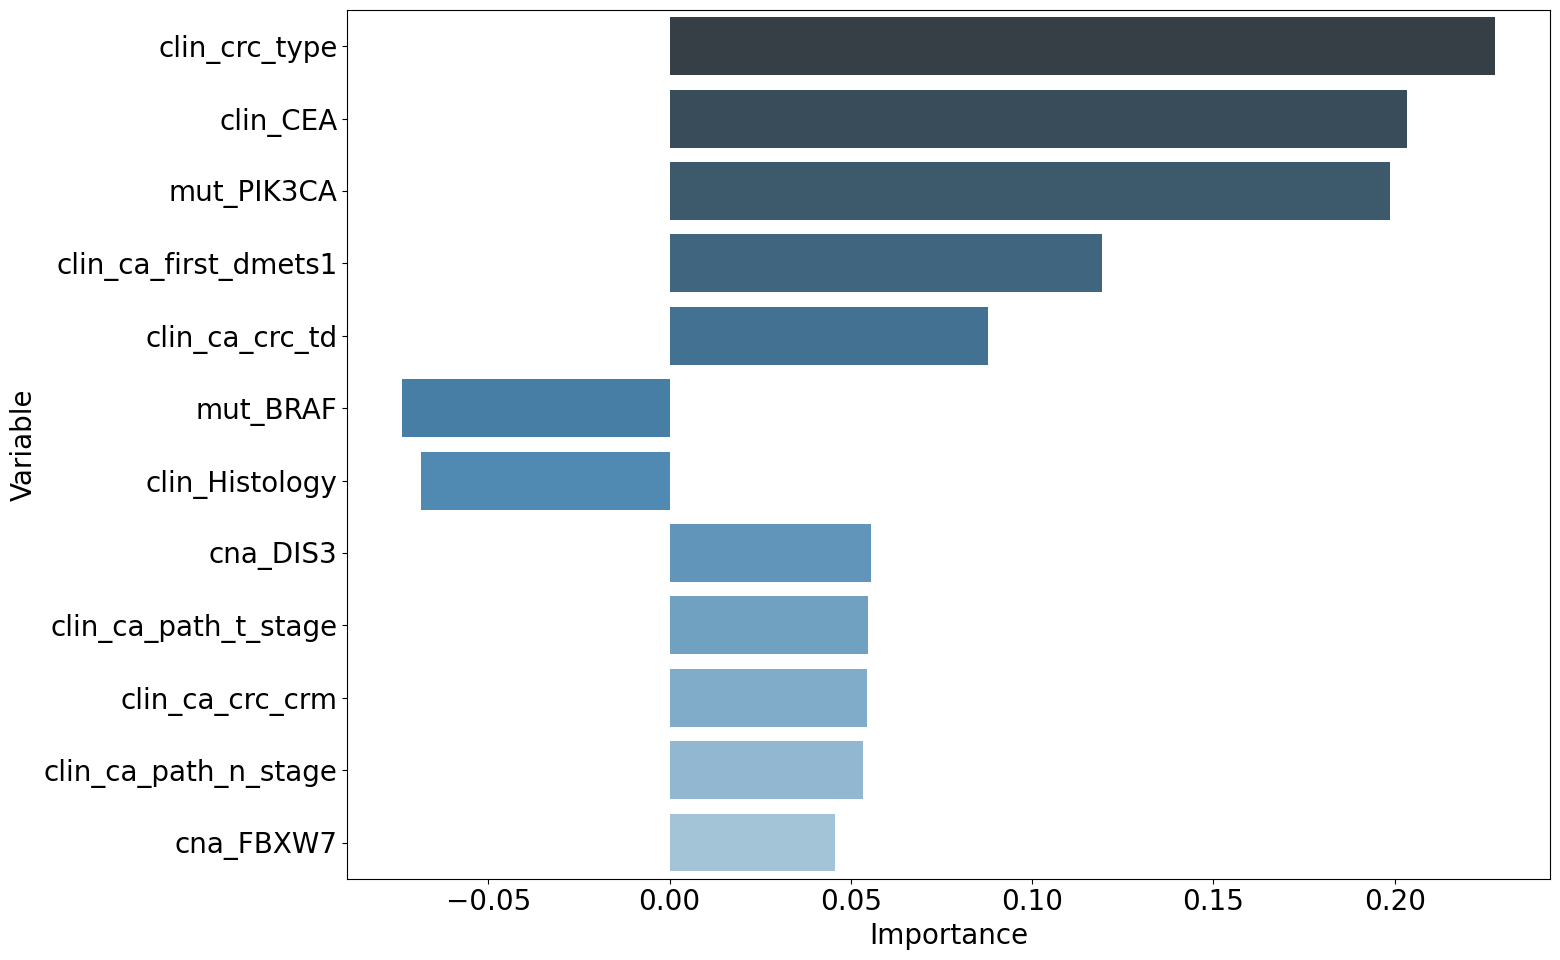

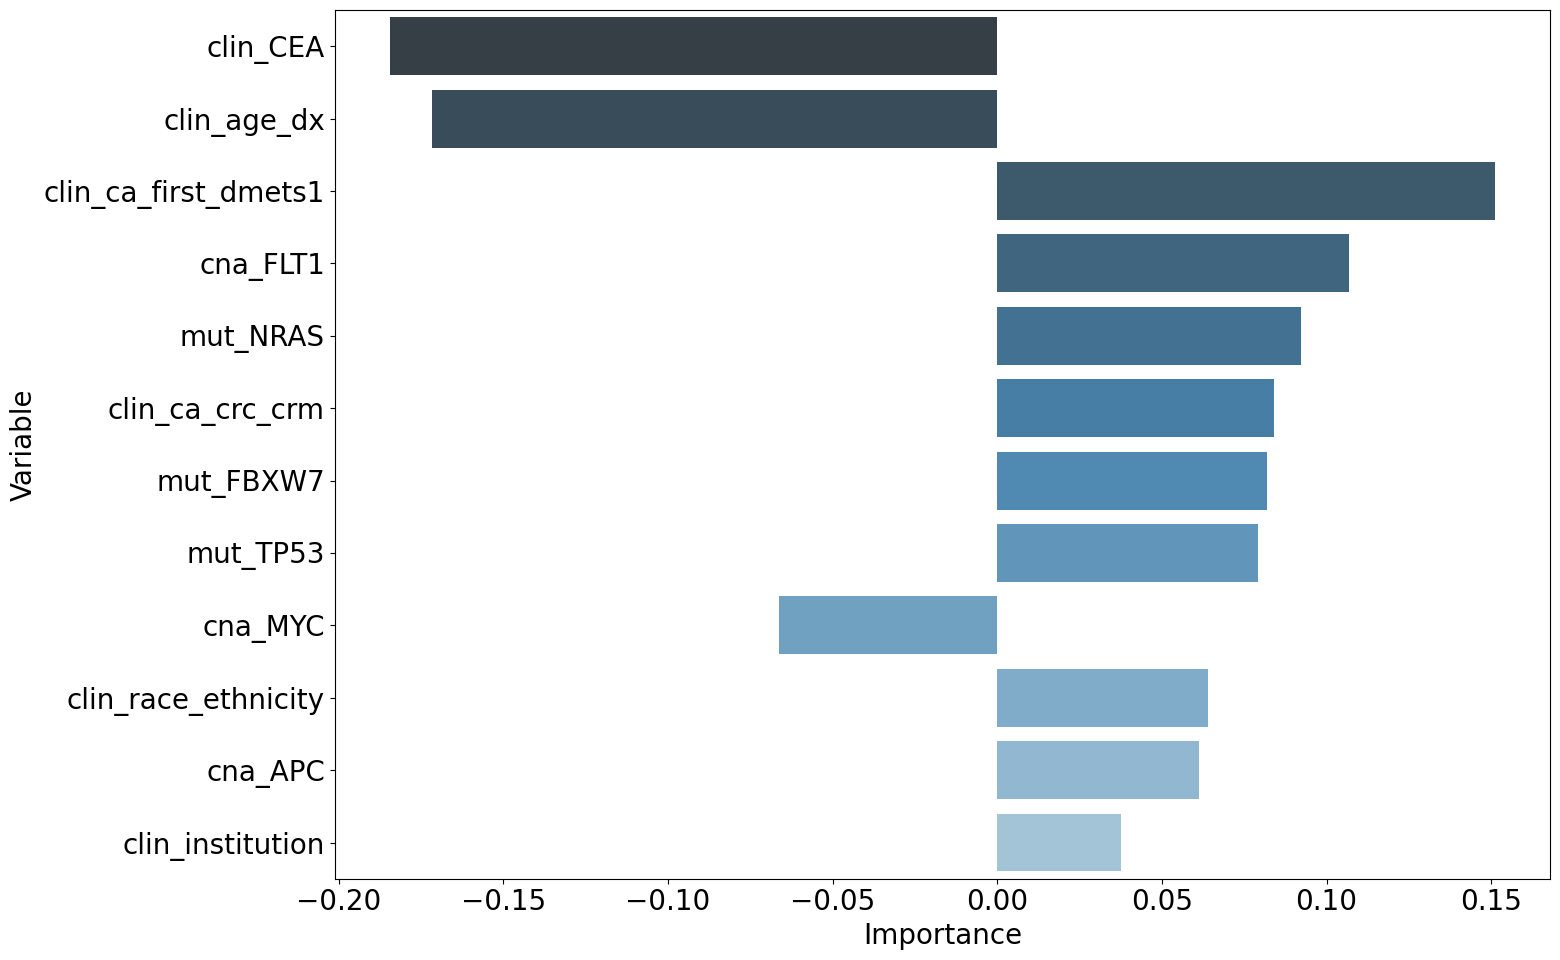

In [15]:
drug = 'folfox'
outcome = 'OS'
for drug in ['folfox', 'egfr', 'vegf', 'ib']:
    for outcome in ['OS', 'PFS']:
        print('Running', drug, outcome)
        data = pd.read_csv('../data/crc_{}_mut_cna_clin.csv'.format(drug), index_col=0)
        data = data.dropna(subset=[outcome])
        X = data[[col for col in data.columns if 'mut_' in col or 'cna_' in col or 'clin_' in col]]
        y = data[outcome]
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)
        print(X_train.shape, X_test.shape)
        xgb = RandomForestClassifier()
        xgb.fit(X_train, y_train)
        res_df = pd.DataFrame(columns=['AUROC', 'AUPRC', 'Recall', 'Precision'])
        auroc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])
        auprc = average_precision_score(y_test, xgb.predict_proba(X_test)[:, 1])
        recall = recall_score(y_test, xgb.predict(X_test))
        precision = precision_score(y_test, xgb.predict(X_test))
        res_df.loc['XGBoost'] = [auroc, auprc, recall, precision]
        print(res_df.head())

        explainer = shap.TreeExplainer(xgb)
        shap_values = explainer.shap_values(X_test)
        shap_obj = explainer(X_test)
        shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

        #get the mean absolute value for each feature
        shap_mean = pd.DataFrame(shap_df.mean(), columns=['importance'])
        shap_mean.index.rename('feature', inplace=True)
        shap_mean['abs_importance'] = np.abs(shap_mean['importance'])
        shap_mean = shap_mean.sort_values('abs_importance', ascending=False)
        fi = shap_mean.copy()

        fi.reset_index(inplace=True)
        fi.rename(columns={'feature':'Variable', 'importance':'Importance'}, inplace=True)
        #makes the darkest blue at the top and lightest blue at the bottom
        palette = sns.color_palette("Blues_d", n_colors=12)
        palette.reverse()
        #create a horizontal bar plot of the top 10 features
        plt.figure(figsize=(16,10))
        sns.barplot(x='Importance', y='Variable', data=fi.head(12), palette=palette)
        #increase font size
        plt.tight_layout()
        plt.rcParams["font.size"] = 20
        plt.savefig('../results/figures/shap/shap_{}_{}.png'.format(drug, outcome), dpi=600, bbox_inches='tight')

In [2]:
drug = 'folfox'
outcome = 'OS'

data = pd.read_csv('../data/crc_{}_mut_cna_clin.csv'.format(drug), index_col=0)
data = data.dropna(subset=[outcome])

In [3]:
X = data[[col for col in data.columns if 'mut_' in col or 'cna_' in col or 'clin_' in col]]
y = data[outcome]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)
print(X_train.shape, X_test.shape)

(1106, 469) (277, 469)


In [4]:
xgb = RandomForestClassifier(n_estimators=1000)
xgb.fit(X_train, y_train)
res_df = pd.DataFrame(columns=['AUROC', 'AUPRC', 'Recall', 'Precision'])
auroc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])
auprc = average_precision_score(y_test, xgb.predict_proba(X_test)[:, 1])
recall = recall_score(y_test, xgb.predict(X_test))
precision = precision_score(y_test, xgb.predict(X_test))
res_df.loc['XGBoost'] = [auroc, auprc, recall, precision]
res_df.head()

,AUROC,AUPRC,Recall,Precision
XGBoost,0.854702,0.865024,0.772414,0.767123


In [6]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test, check_additivity=False)
shap_obj = explainer(X_test)
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

#get the mean value for each feature
shap_mean = pd.DataFrame(shap_df.mean(), columns=['importance'])
shap_mean.index.rename('feature', inplace=True)
shap_mean['abs_importance'] = shap_mean['importance'].abs()
shap_mean = shap_mean.sort_values('abs_importance', ascending=False)
fi = shap_mean.copy()
fi.head()


ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. Consider retrying with the feature_perturbation='interventional' option. This check failed because for one of the samples the sum of the SHAP values was 0.459963, while the model output was 0.462000. If this difference is acceptable you can set check_additivity=False to disable this check.

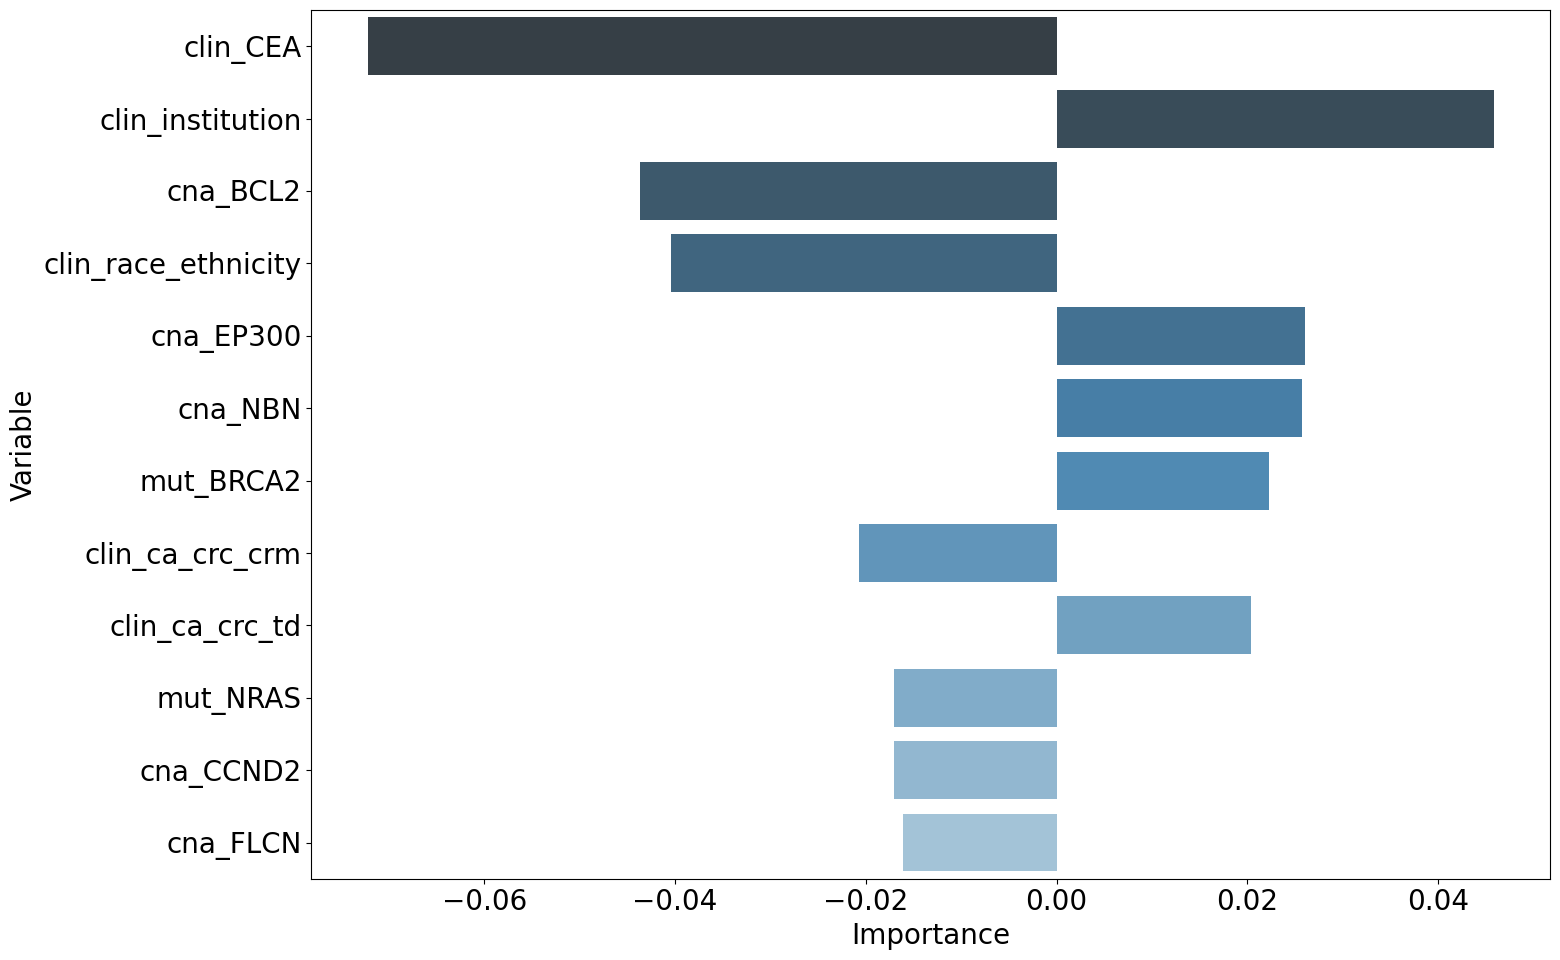

In [ ]:

fi.reset_index(inplace=True)
fi.rename(columns={'feature':'Variable', 'importance':'Importance'}, inplace=True)
#makes the darkest blue at the top and lightest blue at the bottom
palette = sns.color_palette("Blues_d", n_colors=12)
palette.reverse()
#create a horizontal bar plot of the top 10 features
plt.figure(figsize=(16,10))
sns.barplot(x='Importance', y='Variable', data=fi.head(12), palette=palette)
#increase font size
plt.tight_layout()
plt.rcParams["font.size"] = 20
plt.show()